<a href="https://colab.research.google.com/github/jmcmt87/portfolio_computerVision/blob/main/trafficSigns_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image #The PIL library is used to open image content into an array.
from sklearn.model_selection import train_test_split

## Data Loading

In [ ]:
path_train = '/content/drive/MyDrive/Train'
path_test = '/content/drive/MyDrive/Test'

#'/content/drive/MyDrive/Train/1/00001_00000_00000.png'

In [ ]:
data = []
labels = []
classes = len(os.listdir(path_train))
# data is divided by as many directories as there are classes

In [60]:
classes # There are 43 types of traffic signs in this dataset

43

In [ ]:
for i in range(classes):
  path = path_train + '/' + str(i)
  images = os.listdir(path)

  for file in images:
    try:
      image = Image.open(path + '/' + file)
      image = image.resize((30,30))
      image = np.array(image)
      data.append(image)
      labels.append(i) #Every directory has the name of its label
    except:
      print('Error loading image')

data = np.array(data)
labels = np.array(labels)

In [ ]:
np.save('labels_traffic_signs', labels)

In [ ]:
# np.save('labels_traffic_signs', labels)
# np.save('data_traffic_signs', data)
# loaded_array = np.load('data_traffic_signs.npy')
data =  np.load('/content/drive/MyDrive/data_traffic_signs.npy')
labels = np.load('/content/drive/MyDrive/labels_traffic_signs.npy')

In [ ]:
# Let's check the shape of the images

data.shape 

(39176, 30, 30, 3)

We have 39,176 pictures of traffic signs, these pictures are 30x30 and are colored (3 channels RGB).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_train[0].shape)
print(X_train.shape[0])
print(X_test.shape[0])

(31340, 30, 30, 3)
(30, 30, 3)
31340
7836


## CNN Architecture

The architecture we will use for a first model will take inspiration from two well-known architectures: **LeNet** and **AlexNet** architectures:

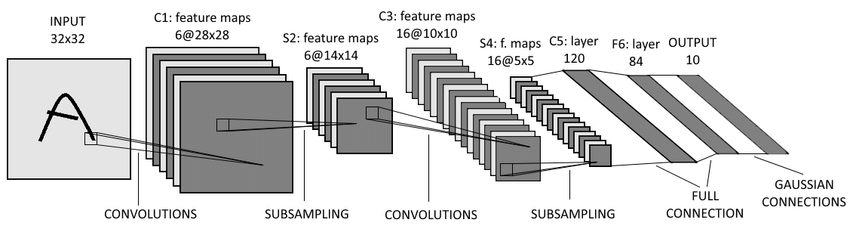

We will use LeNet structure (see image above) as our model backbone, but with some differences that will make it closer to the AlexNet architecture (see image below): subsampling will be carried out using **max pooling** (AlexNet) instead of average pooling (LeNet), also we will be using **ReLU activation functions** (AlexNet) instead of hyperbolic tangents (LeNet):


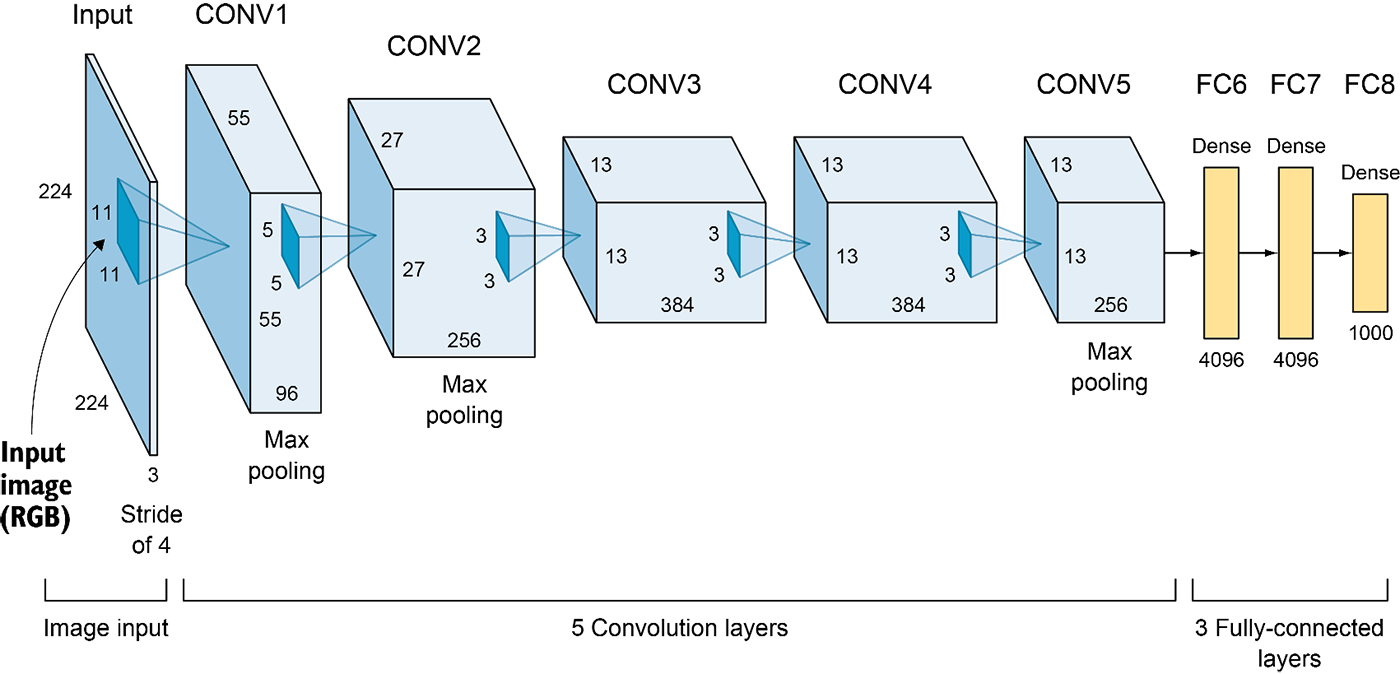

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 5, activation = 'relu', padding = 'same', input_shape = X_train[0].shape),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(classes, activation = 'softmax')
])

The first **kernel** will be **5x5**, bigger than the rest we will use in later layers, thus we will use a **stride of 2**.
We use a bigger kernel at the beginning because this will reduce the spatial dimension of the image without losing too much information, also the input image has only three channels (colors) so it won't be too costly.

The **max pooling layers** we will use will reduce the spatial dimension by 2 every time.

The **number of filters** will grow up with every convolutional layer, the logic behind this scheme is that the number of low-level features is often low (edges, small circles, etc.) but there are many different ways to combine them into higher-level-features. It is common practice to double the number of filters after each pooling layer: the pooling layer shrinks the spatial dimension by two, so we can afford to double the feature maps in the next level without fear of exploding the number of parameters.

Next is the **fully connected layer**, composed of two hidden dense layers and a dense **output layer (softmax)**. We also add regularizations at this points (a **dropout of 50%** in each hidden layer).

We will try using **padding** in order to not change the size of the image on the next layer, we will try removing the padding later on and see what difference makes.

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 35, verbose = 0)

In [ ]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

245/245 [==============================] - 1s 5ms/step - loss: 0.2040 - accuracy: 0.9350


[0.20404206216335297, 0.9350433945655823]

In [ ]:
model.save('traffic_classifier.h5')

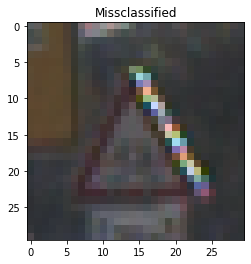

In [ ]:
# Let's a example of missclassified images:

p_test = model.predict(X_test).argmax(axis=1)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("Missclassified");

In this example, we can see that the picture hasn't been taken from a straight angle, that might have something to do with why it got misclassified

## AlexNet architecture

We will try now using an AlexNet architecture, for this model we will add just the necessary padding so we can make it deep enough, AlexNet stacks 2 or more convolutional layers before it gets to the fully conected layers, so in this case, given that we have 30x30 we need to add padding set to 'same' to at least one layer.

In [ ]:
AlexNet_model = keras.models.Sequential([
    keras.layers.Conv2D(64, 5, activation = 'relu', padding = 'same', input_shape = X_train[0].shape),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation = 'relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation = 'relu'),
    keras.layers.Conv2D(256, 3, activation = 'relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(classes, activation = 'softmax')
])

In [ ]:
AlexNet_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
h = AlexNet_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 45, verbose = 0)

In [ ]:
AlexNet_model.evaluate(X_train, y_train)
AlexNet_model.evaluate(X_test, y_test)

245/245 [==============================] - 1s 6ms/step - loss: 0.2657 - accuracy: 0.9461


[0.2657139301300049, 0.9461460113525391]

We can see this model has outperformed our previous customized model. Let's see how the accuracy and cost value performed during the different epochs:

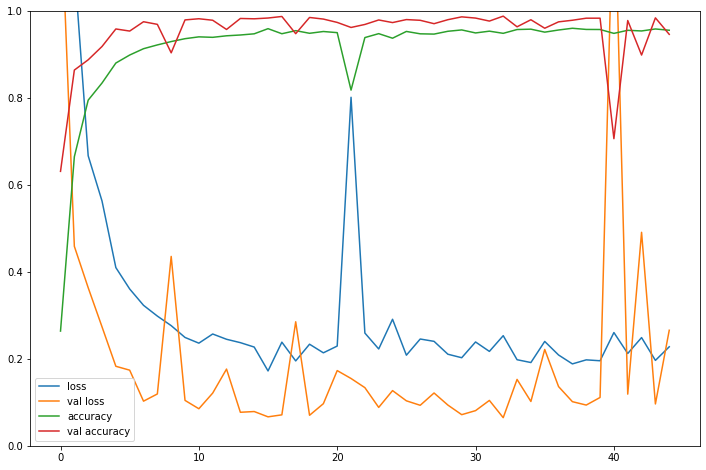

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(h.history['loss'], label = 'loss')
plt.plot(h.history['val_loss'], label = 'val loss')
plt.plot(h.history['accuracy'], label = 'accuracy')
plt.plot(h.history['val_accuracy'], label = 'val accuracy')
plt.gca().set_ylim(0,1)
plt.legend()

We can see how the lines oscillate all across the gradient descent, it seems like it overshoots sometimes so we should try a smaller learning rate in the future.

In [ ]:
AlexNet_model.save('AlexNet_traffic_classifier.h5')